In [54]:
# Imports & settingsimport pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

DATA_PATH = "../data/cleaned/all_parks_recreation_visits.csv"


In [55]:
#Load data & quick peekdf = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (28207, 9)


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits,Date
0,Andersonville NHS,ANDE,National Historic Site,Southeast,GA,1979,1,7589,1979-01-01
1,Andersonville NHS,ANDE,National Historic Site,Southeast,GA,1979,2,10986,1979-02-01
2,Andersonville NHS,ANDE,National Historic Site,Southeast,GA,1979,3,17856,1979-03-01
3,Andersonville NHS,ANDE,National Historic Site,Southeast,GA,1979,4,19940,1979-04-01
4,Andersonville NHS,ANDE,National Historic Site,Southeast,GA,1979,5,12927,1979-05-01


In [4]:
# enforce numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
df["Recreation Visits"] = pd.to_numeric(df["Recreation Visits"], errors="coerce")

In [9]:
# drop invalid rows
df = df.dropna(subset=["Year","Month","Recreation Visits"])
df["Year"] = df["Year"].astype(int)
df["Month"] = df["Month"].astype(int)
df["Recreation Visits"] = df["Recreation Visits"].astype(int)


In [11]:
# date column for time analysis
df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))


In [12]:
# de-dup just in case
before = len(df)
df = df.drop_duplicates()
print(f"Rows after clean/dedup: {len(df)} (dropped {before - len(df)})")

df.describe(include="all")

Rows after clean/dedup: 28207 (dropped 0)


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits,Date
count,28207,28207,28207,28207,27751,28207.000000,28207.000000,2.820700e+04,28207
unique,59,59,15,7,24,NaN,NaN,NaN,NaN
top,Andersonville NHS,ANDE,National Monument,Intermountain,UT,NaN,NaN,NaN,NaN
freq,552,552,7260,9912,2760,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2002.539051,6.500372,7.681899e+04,2002-12-30 11:32:55.041656448
min,NaN,NaN,NaN,NaN,NaN,1979.000000,1.000000,0.000000e+00,1979-01-01 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,1991.000000,4.000000,4.000000e+03,1991-10-01 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,2003.000000,7.000000,1.705000e+04,2003-07-01 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,2014.000000,9.500000,6.001800e+04,2014-08-01 00:00:00
max,NaN,NaN,NaN,NaN,NaN,2024.000000,12.000000,3.181024e+06,2024-12-01 00:00:00


In [14]:
# Sanity checks (missing, ranges)
print("Year range:", df["Year"].min(), "→", df["Year"].max())
print("Months unique:", sorted(df["Month"].unique()))
print("Parks:", df["Park"].nunique(), "| States:", df["State"].nunique(), "| Regions:", df["Region"].nunique())

# Basic missing check (should be none after dropna)
df.isna().sum()

Year range: 1979 → 2024
Months unique: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
Parks: 59 | States: 24 | Regions: 7


Park                   0
Unit Code              0
Park Type              0
Region                 0
State                456
Year                   0
Month                  0
Recreation Visits      0
Date                   0
dtype: int64

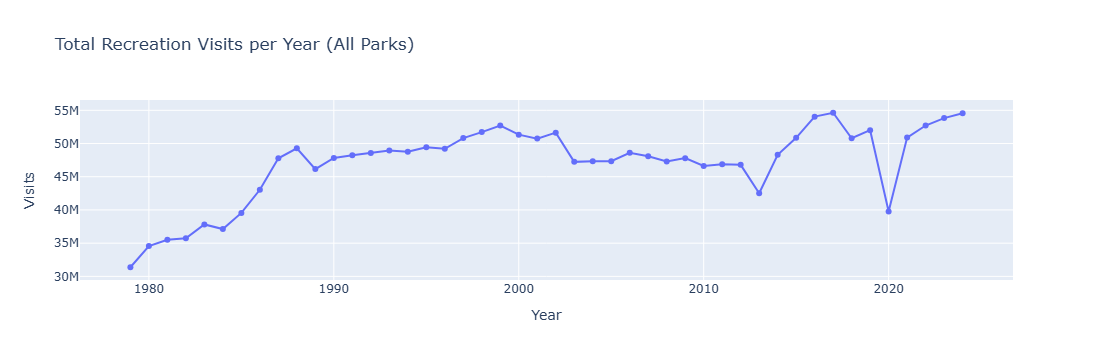

In [15]:
#Totals by year (interactive)
yearly = df.groupby("Year", as_index=False)["Recreation Visits"].sum()

fig = px.line(
    yearly, x="Year", y="Recreation Visits",
    title="Total Recreation Visits per Year (All Parks)",
    markers=True
)
fig.update_layout(yaxis_title="Visits", xaxis_title="Year")
fig.show()


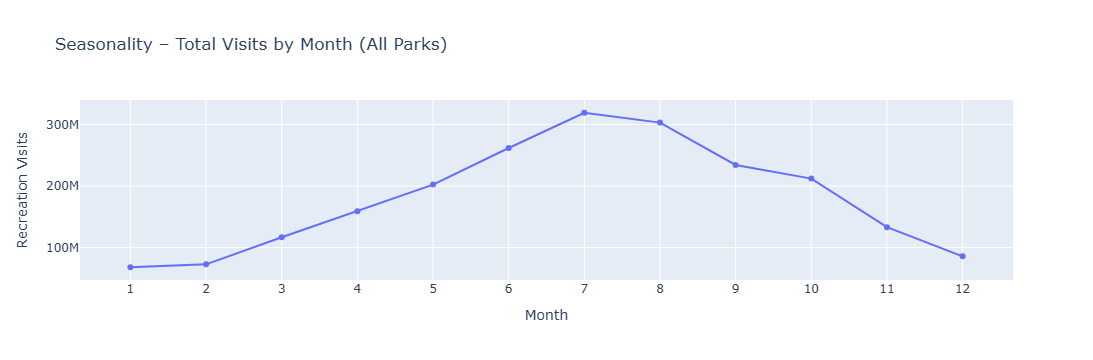

In [16]:
# Seasonality (all parks combined)
monthly = df.groupby("Month", as_index=False)["Recreation Visits"].sum().sort_values("Month")

fig = px.line(
    monthly, x="Month", y="Recreation Visits",
    title="Seasonality – Total Visits by Month (All Parks)",
    markers=True
)
fig.update_xaxes(dtick=1)
fig.show()


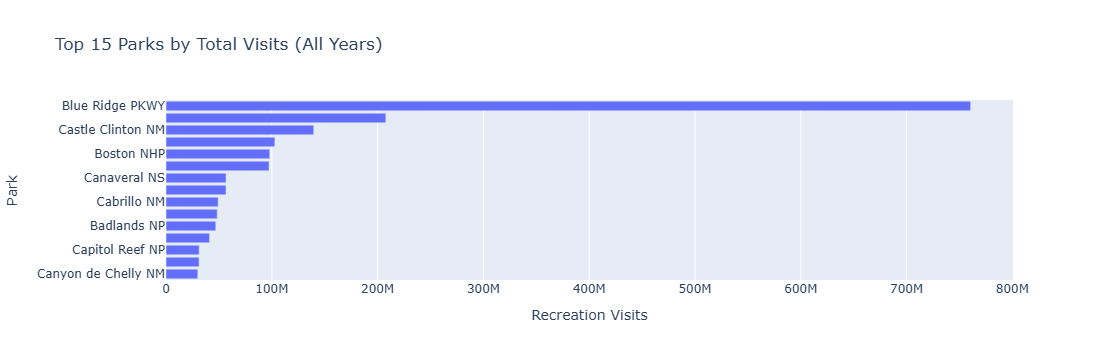

In [17]:
# Top 15 parks (all time)
top_parks = (
    df.groupby("Park", as_index=False)["Recreation Visits"].sum()
      .sort_values("Recreation Visits", ascending=False)
      .head(15)
)

fig = px.bar(
    top_parks, x="Recreation Visits", y="Park",
    orientation="h", title="Top 15 Parks by Total Visits (All Years)"
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [41]:
# YoY growth per park, latest month per park ---

# 1) Monthly panel per park
park_month = (
    df.groupby(["Park","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
park_month["Date"] = pd.to_datetime(dict(year=park_month["Year"], month=park_month["Month"], day=1))


In [26]:
# 2) Previous-year same-month baseline
park_month = park_month.sort_values(["Park","Date"])
park_month["Prev_Year_Visits"] = park_month.groupby("Park")["Recreation Visits"].shift(12)

In [27]:
# 3) YoY growth
park_month["YoY_Growth"] = (
    (park_month["Recreation Visits"] - park_month["Prev_Year_Visits"]) / park_month["Prev_Year_Visits"]
)

In [28]:
# 4) Get the latest row per park (no groupby-apply, so no warning)
latest_idx = park_month.groupby("Park")["Date"].idxmax()
latest = park_month.loc[latest_idx].copy()


In [29]:
# 5) Keep only parks with a valid YoY baseline
latest = latest.replace([np.inf, -np.inf], np.nan).dropna(subset=["YoY_Growth"])

# 6) Top gainers / decliners
top_gainers   = latest.sort_values("YoY_Growth", ascending=False).head(10)
top_decliners = latest.sort_values("YoY_Growth", ascending=True).head(10)

print("Top YoY Gainers:")
display(top_gainers[["Park","Year","Month","Recreation Visits","Prev_Year_Visits","YoY_Growth"]])

print("\nTop YoY Decliners:")
display(top_decliners[["Park","Year","Month","Recreation Visits","Prev_Year_Visits","YoY_Growth"]])

Top YoY Gainers:


,Park,Year,Month,Recreation Visits,Prev_Year_Visits,YoY_Growth
4823,Arlington House The R.E. Lee MEM,2024,12,18689,6064.0,2.081959
14159,Boston Harbor Islands NRA,2024,12,2500,950.0,1.631579
24199,Casa Grande Ruins NM,2024,12,9499,3963.0,1.396922
13115,Bluestone NSR,2024,12,639,300.0,1.130000
27103,Chaco Culture NHP,2024,12,1984,937.0,1.117396
26551,Cesar E. Chavez NM,2024,12,1658,846.0,0.959811
7031,Bandelier NM,2024,12,17514,9140.0,0.916193
18619,Canyon de Chelly NM,2024,12,40150,22456.0,0.787941
18067,Cane River Creole NHP,2024,12,1248,724.0,0.723757
8999,Big Cypress NPRES,2024,12,319976,206798.0,0.547288



Top YoY Decliners:


,Park,Year,Month,Recreation Visits,Prev_Year_Visits,YoY_Growth
22999,Carl Sandburg Home NHS,2024,12,1598,9455.0,-0.830989
7691,Bent's Old Fort NHS,2024,12,156,638.0,-0.755486
1103,Andrew Johnson NHS,2024,12,2190,8597.0,-0.745260
27655,Chamizal NMEM,2024,12,399,871.0,-0.541906
5927,Aztec Ruins NM,2024,12,1176,2463.0,-0.522533
16639,Buffalo NR,2024,12,33135,46787.0,-0.291790
28206,Channel Islands NP,2024,12,14893,19088.0,-0.219772
3167,Appomattox Court House NHP,2024,12,2294,2887.0,-0.205404
16087,Buck Island Reef NM,2024,12,3583,4337.0,-0.173853
9551,Big Hole NB,2024,12,360,419.0,-0.140811


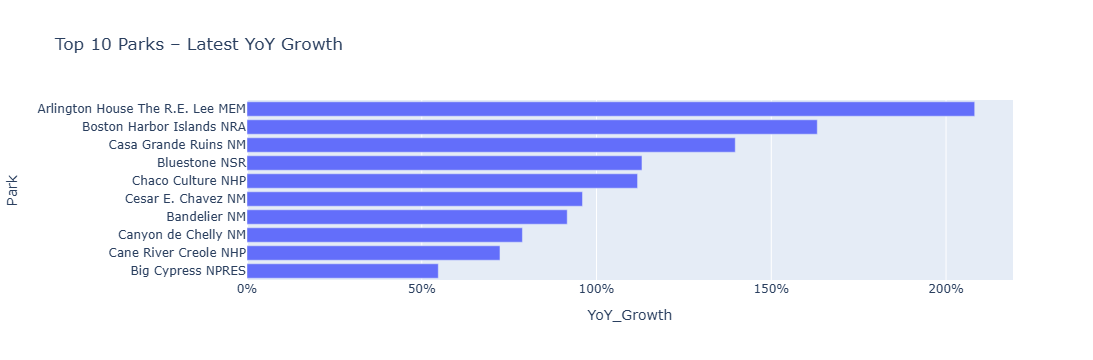

In [30]:
import plotly.express as px

fig = px.bar(
    top_gainers.sort_values("YoY_Growth"),
    x="YoY_Growth", y="Park", orientation="h",
    title="Top 10 Parks – Latest YoY Growth"
)
fig.update_layout(xaxis_tickformat=".0%")
fig.show()


In [31]:
# State & Region summaries (for map and dashboard)
# State-month
state_month = (
    df.groupby(["State","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
state_month["Date"] = pd.to_datetime(dict(year=state_month["Year"], month=state_month["Month"], day=1))

In [32]:
# Region-month
region_month = (
    df.groupby(["Region","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
region_month["Date"] = pd.to_datetime(dict(year=region_month["Year"], month=region_month["Month"], day=1))

In [33]:
# (map & filters)
state_month.to_csv("../data/cleaned/state_month_visits.csv", index=False)
region_month.to_csv("../data/cleaned/region_month_visits.csv", index=False)

state_month.head(), region_month.head()

(  State  Year  Month  Recreation Visits       Date
 0    AK  1982      1                  0 1982-01-01
 1    AK  1982      2                  0 1982-02-01
 2    AK  1982      3                 25 1982-03-01
 3    AK  1982      4                245 1982-04-01
 4    AK  1982      5                565 1982-05-01,
    Region  Year  Month  Recreation Visits       Date
 0  Alaska  1982      1                  0 1982-01-01
 1  Alaska  1982      2                  0 1982-02-01
 2  Alaska  1982      3                 25 1982-03-01
 3  Alaska  1982      4                245 1982-04-01
 4  Alaska  1982      5                565 1982-05-01)

In [34]:
# Seasonality index (per park)
park_month_total = (
    df.groupby(["Park","Month"], as_index=False)["Recreation Visits"].sum()
)

park_total_year = (
    df.groupby("Park", as_index=False)["Recreation Visits"].sum()
      .rename(columns={"Recreation Visits":"Total_Visits"})
)

In [35]:
# average per month = total / number of unique months present for the park
months_per_park = df.groupby("Park")["Month"].nunique().reset_index().rename(columns={"Month":"Months_Count"})
park_total_year = park_total_year.merge(months_per_park, on="Park", how="left")

park_month_avg = park_month_total.merge(park_total_year, on="Park", how="left")
park_month_avg["Avg_Per_Month"] = park_month_avg["Total_Visits"] / park_month_avg["Months_Count"]

In [36]:
#  index: month_visits / avg_per_month
park_month_avg["Seasonality_Index"] = park_month_avg["Recreation Visits"] / park_month_avg["Avg_Per_Month"]

# 
park_month_avg.to_csv("../data/cleaned/park_seasonality_index.csv", index=False)
park_month_avg.head()

,Park,Month,Recreation Visits,Total_Visits,Months_Count,Avg_Per_Month,Seasonality_Index
0,Andersonville NHS,1,305421,6127849,12,510654.083333,0.598098
1,Andersonville NHS,2,428142,6127849,12,510654.083333,0.838419
2,Andersonville NHS,3,579494,6127849,12,510654.083333,1.134807
3,Andersonville NHS,4,634006,6127849,12,510654.083333,1.241557
4,Andersonville NHS,5,804108,6127849,12,510654.083333,1.574663


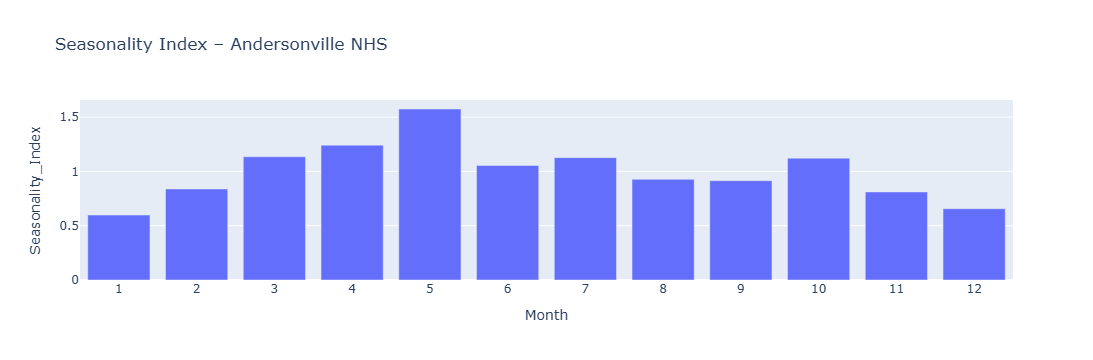

In [37]:
# Heatmap for one park example:
one = park_month_avg[park_month_avg["Park"] == park_month_avg["Park"].iloc[0]]
fig = px.bar(one, x="Month", y="Seasonality_Index", title=f"Seasonality Index – {one['Park'].iloc[0]}")
fig.update_xaxes(dtick=1)
fig.show()


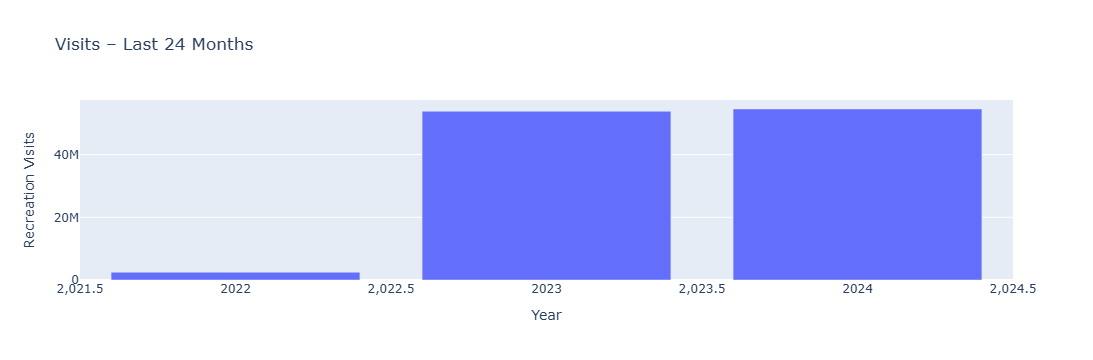

,State,Date,Recreation Visits
0,AK,2022-12-01,1972
250,MD,2022-12-01,74346
325,NM,2022-12-01,48709
525,WI,2022-12-01,2467
50,AZ,2022-12-01,29569


In [38]:
# Recent period focus (last 24 months)
cutoff = df["Date"].max() - pd.DateOffset(months=24)
recent = df[df["Date"] >= cutoff].copy()

recent_yearly = recent.groupby("Year", as_index=False)["Recreation Visits"].sum()
px.bar(recent_yearly, x="Year", y="Recreation Visits", title="Visits – Last 24 Months").show()

recent_monthly_state = (
    recent.groupby(["State","Date"], as_index=False)["Recreation Visits"].sum()
)
recent_monthly_state.sort_values("Date").head()


In [39]:
# Save EDA artifacts for the dashboard
df.to_csv("../data/cleaned/_eda_base_all_rows.csv", index=False)
yearly.to_csv("../data/cleaned/_eda_yearly_totals.csv", index=False)
monthly.to_csv("../data/cleaned/_eda_monthly_totals.csv", index=False)
top_parks.to_csv("../data/cleaned/_eda_top_parks_total.csv", index=False)
park_month.to_csv("../data/cleaned/_eda_park_month_panel.csv", index=False)
latest.to_csv("../data/cleaned/_eda_latest_yoy_per_park.csv", index=False)


In [40]:
# Quick data-quality flags
# Impossible month values?
print("Bad months:", df.loc[~df["Month"].between(1,12)].shape[0])

# Extremely large spikes (top 0.1%)
cap = df["Recreation Visits"].quantile(0.999)
spikes = df[df["Recreation Visits"] >= cap].sort_values("Recreation Visits", ascending=False)
print(f"Extreme spikes (>= {int(cap)}):", len(spikes))
spikes.head(10)


Bad months: 0
Extreme spikes (>= 2439625): 29


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits,Date
12669,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1987,10,3181024,1987-10-01
12846,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,2002,7,2899584,2002-07-01
12681,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1988,10,2854160,1988-10-01
12644,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1985,9,2827523,1985-09-01
12654,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1986,7,2797084,1986-07-01
12679,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1988,8,2751655,1988-08-01
12837,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,2001,10,2680206,2001-10-01
12678,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1988,7,2657826,1988-07-01
12667,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1987,8,2656403,1987-08-01
12666,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1987,7,2613325,1987-07-01


In [45]:
# Hotspot vs Off-Season Labeling by State
# Hotspot vs Off-Season labeling ---

selected_year  = 2024
selected_month = 7

# 1) Filter for that month
month_df = df[(df["Year"] == selected_year) & (df["Month"] == selected_month)]

# 2) Aggregate at state level
state_avg = (
    month_df.groupby("State", as_index=False)["Recreation Visits"].mean()
)

# 3) Determine thresholds
hot_threshold = state_avg["Recreation Visits"].quantile(0.75)
cold_threshold = state_avg["Recreation Visits"].quantile(0.25)

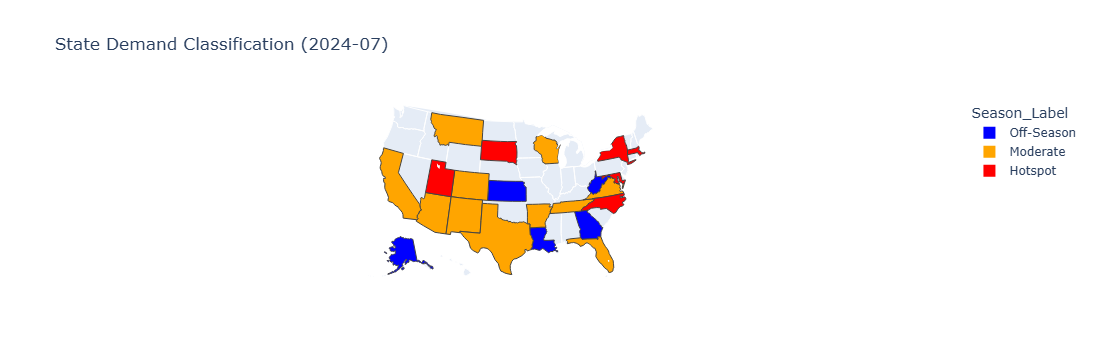

In [46]:
# 4) Assign category
state_avg["Season_Label"] = state_avg["Recreation Visits"].apply(
    lambda x: "Hotspot" if x >= hot_threshold else ("Off-Season" if x <= cold_threshold else "Moderate")
)

# 5) Visualize
import plotly.express as px

fig = px.choropleth(
    state_avg,
    locations="State", locationmode="USA-states",
    color="Season_Label",
    title=f"State Demand Classification ({selected_year}-{selected_month:02d})",
    scope="usa",
    color_discrete_map={"Hotspot":"red","Moderate":"orange","Off-Season":"blue"}
)
fig.show()

In [48]:
# 1) Create monthly series per park
park_ts = (
    df.groupby(["Park","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
park_ts["Date"] = pd.to_datetime(dict(year=park_ts["Year"], month=park_ts["Month"], day=1))

In [50]:
# 2) Sort and compute rolling sum
park_ts = park_ts.sort_values(["Park","Date"])
park_ts["Rolling_12M"] = park_ts.groupby("Park")["Recreation Visits"].transform(lambda x: x.rolling(12, min_periods=6).sum())

# 3) Compute month-to-month growth
park_ts["Rolling_Growth"] = park_ts.groupby("Park")["Rolling_12M"].pct_change(fill_method=None)


In [51]:
# Get latest available growth
latest_rows = park_ts.groupby("Park")["Date"].idxmax()
latest_growth = park_ts.loc[latest_rows].dropna(subset=["Rolling_Growth"])

# Top trending
top_trending = latest_growth.sort_values("Rolling_Growth", ascending=False).head(10)

print("Top 10 Trending Parks (12-Month Rolling Growth):")
display(top_trending[["Park","Rolling_12M","Rolling_Growth"]])


Top 10 Trending Parks (12-Month Rolling Growth):


,Park,Rolling_12M,Rolling_Growth
14159,Boston Harbor Islands NRA,28157.0,0.058255
24199,Casa Grande Ruins NM,104429.0,0.055980
8999,Big Cypress NPRES,2216708.0,0.053804
13115,Bluestone NSR,7327.0,0.048512
18619,Canyon de Chelly NM,387433.0,0.047855
18067,Cane River Creole NHP,12592.0,0.043421
7031,Bandelier NM,213595.0,0.040805
26551,Cesar E. Chavez NM,26641.0,0.031438
2063,Antietam NB,197340.0,0.030884
551,Andersonville NHS,72925.0,0.029505


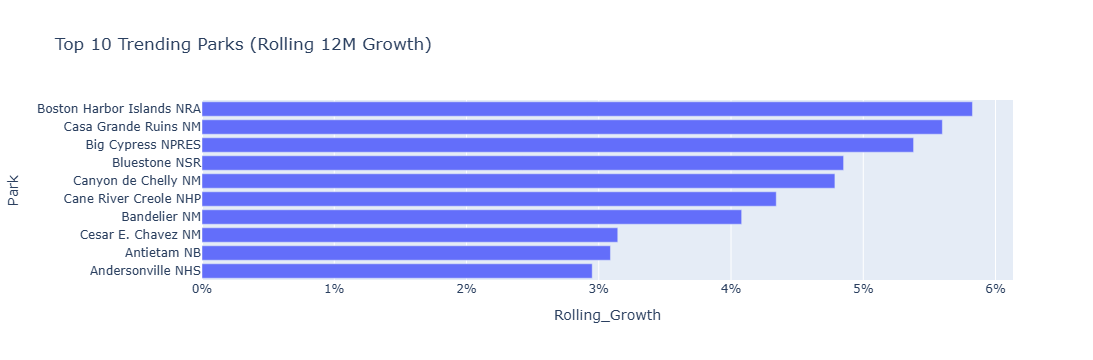

In [53]:
# Chart
fig = px.bar(
    top_trending.sort_values("Rolling_Growth"),
    x="Rolling_Growth", y="Park", orientation="h",
    title="Top 10 Trending Parks (Rolling 12M Growth)"
)
fig.update_layout(xaxis_tickformat=".0%")
fig.show()